# Classification using ```pytorch``` - Logistic Regression Classifier
The first thing we're going to do, as usual, is begin by importing libraries and modules we're going to use today. We're introducing a new library, called ```datasets```, which is part of the ```huggingface``` unviverse. 

```datasets``` provides easy access to a wide range of example datasets which are widely-known in the NLP world, it's worth spending some time looking around to see what you can find. For example, here are a collection of [multilabel classification datasets](https://huggingface.co/datasets?task_ids=task_ids:multi-class-classification&sort=downloads).

We'll be working with the ```huggingface``` ecosystem more and more as we progress this semester.

In [1]:
# system tools
import os

# pytorch
import torch
import torch.nn as nn

# data processing
import pandas as pd
import numpy as np

# huggingface datasets
from datasets import load_dataset

# scikit learn tools
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

# plotting tools
import matplotlib.pyplot as plt


__Creating a model class__

The most effective way to work with ```pytorch``` is by using its built-in abstractions to create classes which describe specfic models.

In the following cell, we're defining the Logistic Regression classifier model. Notice how we use the ```super()```, which means that our model _inherits_ everything from the parent class, such as backpropagation methods.

In [2]:
class Model(nn.Module):
    def __init__(self, n_input_features=10):            # default input features, can be overridden
        super().__init__()                              # inherit from parent class
        self.linear = nn.Linear(n_input_features, 1)    # one linear layer with single output

    def forward(self, x):                               # how should one forward pass look?
        x = self.linear(x)                              # pass the data through the linear layer
        y_pred = torch.sigmoid(x)                       # squash the outputs through sigmoid layer
        return y_pred                                   # return predictions

## Load data
We're going to be working with actual text data data, specifically a subset of the well-known [GLUE Benchmarks](https://gluebenchmark.com/). These benchmarks are regularly used to test how well certain models perform across a range of different language tasks. We'll work today specifically with the Stanford Sentiment Treebank 2 (SST2) - you can learn more [here](https://huggingface.co/datasets/glue) and [here](https://nlp.stanford.edu/sentiment/index.html).

The dataset we get back is a complex, hierarchical object with lots of different features. I recommend that you dig around a little and see what it contains. For today, we're going to work with only the training dataset right now, and we're going to split it into sentences and labels.

In [4]:
# load the sst2 dataset
dataset = load_dataset("glue", "sst2")
# select the train split
data = dataset["train"]
X = data["sentence"]
y = data["label"]

Found cached dataset glue (/home/coder/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]


## Create document representations
We're going to work with a bag-of-words model, which we can create quite simply using the ```CountVectorizer()``` class available via ```scikit-learn```. You can read more about the defaul parameters of the vectorizer [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

After we initialize the vectorizer, we first _fit_ this vectorizer to our data and then _transform_ the original data into the BoW representation.

Possible follow up questions:

- How does changing the parameters of ```CountVectorizer()``` affect model performance?
- How would you implement your own ```CountVectorizer()```? What steps would be required and in what order?

In [5]:
# vectorizer
vectorizer = CountVectorizer()
# vectorized training data
X_vect = vectorizer.fit_transform(X)
# to tensors
X_vect = torch.tensor(X_vect.toarray(), dtype=torch.float)
y = torch.tensor(list(y), dtype=torch.float)
y = y.view(y.shape[0], 1)


## Initialize parameters
We then want to initialize parameters for our model to use. Like last week, use ```X_vect.shape``` to get the number of features for each document.

We have binary classification problem, so the loss function we will use is the _Binary Cross Entropy_ function, seen here as ```BCELoss()```.

Notice that we're using a new optimization algorithm called ```ADAM```. ADAM is a gradient descent algorithm which works in a way that is a bit more clever than regular Stochastic Gradient Descent. You can read more [here](http://optimization.cbe.cornell.edu/index.php?title=Adam) and the research paper describing ```ADAM``` can be found [here](https://arxiv.org/abs/1412.6980).

In [7]:
# initialize model
n_samples, n_features = X_vect.shape
model = Model(n_input_features=n_features)

# define loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters())

## Train
Once all of the parameters are defined, we then train the model. Notice how the code here is basically identical to the code we saw last week when training a model for linear regression:

- Define number of epochs to train for (iterations)
- Get predictions from the model (```y_hat```)
- Calculate loss based on ```y_hat``` and ```y```
- Backpropagate the loss
- Take step using gradient descent
- Repeat up to n epochs

In [8]:
# train
epochs = 100
print("[INFO:] Training classifier...")
loss_history = []
for epoch in range(epochs):
    # forward
    y_hat = model(X_vect)

    # backward
    loss = criterion(y_hat, y)
    loss_history.append(loss)

    # backpropagation
    loss.backward()
    # take step, reset
    optimizer.step()
    optimizer.zero_grad()

    # some print to see that it is running
    if (epoch + 1) % 10 == 0:
        print(f"epoch: {epoch+1}, loss = {loss.item():.4f}")

print("[INFO:] Finished traning!")

[INFO:] Training classifier...
epoch: 10, loss = 0.6800
epoch: 20, loss = 0.6664
epoch: 30, loss = 0.6536
epoch: 40, loss = 0.6416
epoch: 50, loss = 0.6301
epoch: 60, loss = 0.6193
epoch: 70, loss = 0.6091
epoch: 80, loss = 0.5993
epoch: 90, loss = 0.5900
epoch: 100, loss = 0.5812
[INFO:] Finished traning!


## Evaluate

Now that we've trained a model for 1000 steps, we want to know how well it actually performs when classifying the data. We can test this by just checking how accurately it classifies the training data.

The first thing we do is get predictions from the model for every data point, which we then convert to a ```numpy``` array. Using a ```numpy``` array allows us to easily use the ```classification_report``` available from ```scikit-learn```.

In [9]:
# Plot
predicted = model(X_vect).detach().numpy()
print(classification_report(y, 
                            np.where(predicted > 0.5, 1, 0),
                            target_names = ["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.87      0.74      0.80     29780
    Positive       0.82      0.91      0.86     37569

    accuracy                           0.84     67349
   macro avg       0.85      0.83      0.83     67349
weighted avg       0.84      0.84      0.84     67349



Notice that in the context of machine learning, the name ```recall``` is used in terms of ```sensitivity```.


![ConfusionMatrix](../img/confusionMatrix.jpg "Title")

## Plot loss history

When we plot the history of the loss function, we're able to see _how well_ our model is learning over time. I recommend that you read through [this document](https://www.baeldung.com/cs/learning-curve-ml) to get a feel for what we can learn from these kinds of plots.

We'll be coming back to this again in later weeks. For now, the point is that the curve of our loss function should be smooth and decreasing regularly over time if the model is learning well.

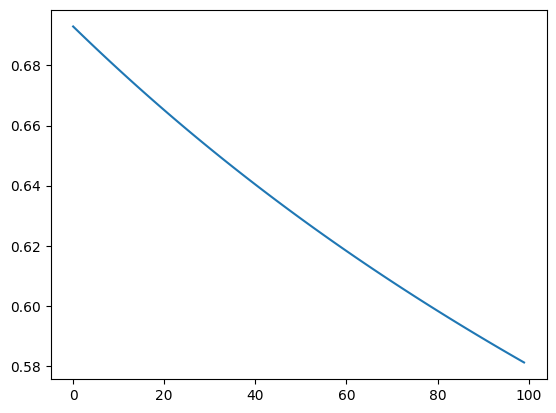

In [10]:
loss_H = [val.item() for val in loss_history]
fig, ax = plt.subplots()
ax.plot(loss_H)

## Questions

- Do you think the model is learning well?
- What problems do we have with this approach so far?
    - Hint: we're only using the _training_ data. What about [_test data_](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets)?
- Where can the model be improved?